# Test of analytical time-to-threshold result

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, special, integrate
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from colour import Color

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkI, join_w
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=0,  # membrane leak potential (V)
    V_TH_E=.05,  # membrane spike threshold (V)
    T_R_E=0,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, E_A=-0.1, T_E=.002, T_I=.002, T_A=0.01,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    N_P_I = 300, # num nrns in inhibitory pool
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E_I=0.1e-3,  # I->E input weights
    W_U_I=0.8e-3,
    W_A=0, # adaptation weight for all neurons
    
    # OTHER INPUTS
    SGM_N=0,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

def set_dynamic_vars(m):
    m.N_E = m.N_L * m.N_L_E
    m.N_N = m.N_E + m.N_P_I

set_dynamic_vars(M)

## SMLN
S = Generic(RNG_SEED=0, DT=.0001)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


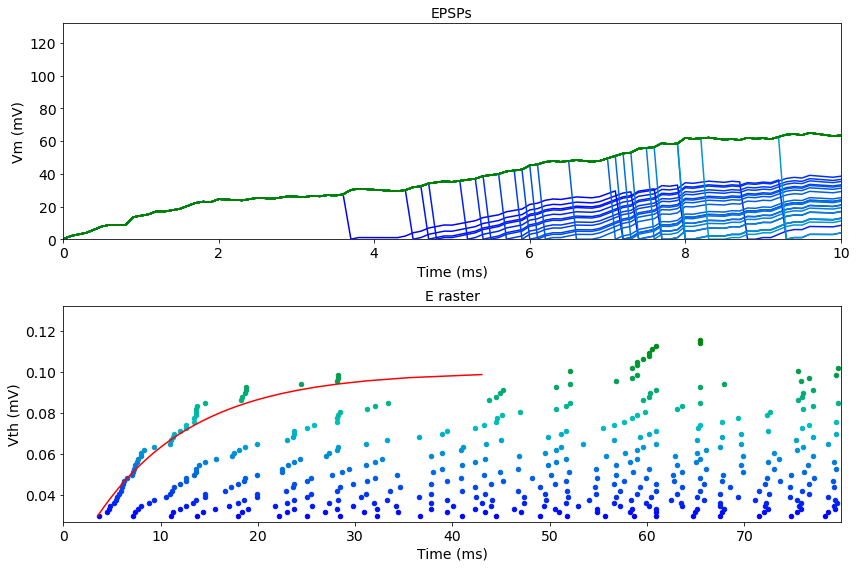

In [294]:
np.random.seed(0)
# EPSP size vs E weight
t = np.arange(0, .08, S.DT)

MAX_INPUTS = M.N_L_E
V_TH_MIN = 0.03
V_TH_MAX = 0.12
N_STEPS_V_TH = 60
LAMBDA = 1e4

rsps_e = []

v_ths = np.linspace(V_TH_MIN, V_TH_MAX, N_STEPS_V_TH)

spks_u = np.zeros((len(t), MAX_INPUTS), dtype=int)
spks_u[:, 0] = np.random.poisson(LAMBDA * S.DT, (len(t)))

for v_th in v_ths:

    ntwk = LIFNtwkI(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=v_th,
        v_r=0,
        t_r=M.T_R_E,
        w_r=np.zeros([1]*2),
        w_u=M.W_E_E_F * np.ones([1, MAX_INPUTS]),
    )
    
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)

    rsps_e.append(copy(rsp))


# plot
fig, axs = plt.subplots(2, 1, figsize=(12, 8), tight_layout=True)

colors_e = list(Color('blue').range_to(Color('green'), len(rsps_e)))

for idx, rsp_e in enumerate(rsps_e):
    axs[0].plot(1000*t, 1000*rsp_e.vs[:, 0], color=colors_e[idx].hex, label=f'V_TH: {v_ths[idx]}')
    axs[1].scatter(1000*rsp_e.spks_t, [v_ths[idx]]*(len(rsp_e.spks_t)), color=colors_e[idx].hex, s=20)

axs[0].set_xlim(1000*t.min(), 10)
axs[0].set_ylim(0, 1.1 * V_TH_MAX * 1000)
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Vm (mV)')
# axs[0].legend()
axs[0].set_title('EPSPs')

axs[1].set_xlim(1000*t.min(), 1000*t.max())
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Vth (mV)')
axs[1].set_title('E raster')
axs[1].set_ylim(0.9 * V_TH_MIN, 1.1 * V_TH_MAX)

TAU = M.C_M_E / M.G_L_E
a = M.W_E_E_F / (M.C_M_E / S.DT)


def t_delay(v_th, tau, a, l, print_on=False):
    if print_on:
        print('a', a)
        print('l', l)
        print('tau', tau)
        print('a * tau * l', a * l * tau)
    return -1 * tau * np.log(1 - v_th / (a * l * tau))


t_delay_s = t_delay(v_ths, TAU, M.W_E_E_F / (M.C_M_E / S.DT), LAMBDA)

axs[1].plot(t_delay_s * 1000, v_ths, c='red')

for ax in axs.flatten():
    set_font_size(ax, 14)

Adrienne showed last week that a single LIF neuron with current-based synapses driven by Poisson input of frequency $\lambda$ will spike after time $t^{*}$:

$$ t^{*} = -\tau \log ({1 - \frac{V^*}{A \lambda \tau}}) $$

Or equivalently:

$$ V^* = A \lambda \tau (1 - e^{-t^*/\tau}) $$

These relations also hold when we replace $\lambda$ with a constant firing rate peaked at $k$.

$$ \int^{t^*}_{0} d \Delta t \, P(\Delta t) A e^{- \Delta t / \tau} =
   \int^{t^*}_{0} d \Delta t \, k A e^{- \Delta t / \tau} =
   V^* $$

</br>

At a constant firing rate, $k$ must exceed $\frac{V^*}{A \tau} \, (k_{min})$ for $t^*$ to be defined (the term inside the log is negative otherwise). If the input takes a frequency $k < k_{min}$, then the neuron will never fire. Therefore, all the probability associated with $k < k_{min}$ in the input is not associated with a corresponding $t^*$.

A crude way in which to enhance our prediction of average time to spike is to discard all frequencies below $k_{min}$ and adjust $\lambda$, the average firing rate of the distribution, accordingly.

First, let us define the normalization term of the Poisson distribution when we have discarding frequencies below $k_{min}$:

$$ \sum^{\infty}_{k \, = \, k_{min}} \frac{\lambda^{k} e^{-\lambda}}{k!} = 1 - CDF(\lambda, k_{min}) = 1 - Q(k_{min} + 1, \lambda) $$

where $Q$ is the regularized gamma function.

Define:

$$ N(k, \lambda) = 1 - Q(k + 1, \lambda) $$

We now calculate $\lambda'$, the adjusted average firing rate:

$$\lambda' = \frac{1}{N(k_{min}, \lambda)} \sum^{\infty}_{k \, = \, k_{min}} k \frac{\lambda^{k} e^{-\lambda}}{k!} =
             \frac{1}{N(k_{min}, \lambda)} \lambda \sum^{\infty}_{k \, = \, k_{min}} \frac{\lambda^{k-1} e^{-\lambda}}{(k-1)!} = 
             \frac{N(k_{min} - 1, \lambda)}{N(k_{min}, \lambda)} \lambda$$

Redoing Adrienne's calculation, we then have:

$$ t^{*} = -\tau \log ({1 - \frac{V^*}{A \lambda' \tau}}) $$
             
Separately, we might guess this distribution of $P(t^*)$ is:

$$ P(t^*) = \frac{\lambda^{k(t^*)} e^{-\lambda}}{k(t^*)!} $$

where

$$ k(t^*) = \frac{V^*}{A \tau (1 - e^{t^*/\tau})} $$

In [295]:
def calc_k(v_th, tau, a, l, t):
    return v_th / (a * tau * (1 - np.exp(-t / tau)))

In [374]:
def prob_t(v_th, tau, a, l, t):
    k = calc_k(v_th, tau, a, l, t)
    f = (l / k) / np.exp(l/k - 1)
    p = np.divide(np.power(f, k), np.sqrt(2 * np.pi * k))
    return p

def prob_t_2(v_th, tau, a, l, t):
    k_min = v_th / (tau * a)
    
def poisson_prob_over_k(k, l):
    return 1. - special.gammaincc(k + 1, l)

In [370]:
print('t_delay', t_delay(0.05, TAU, a, 10000))

t_delay 0.0069314718055994515


a_prime 0.0008000000000000003


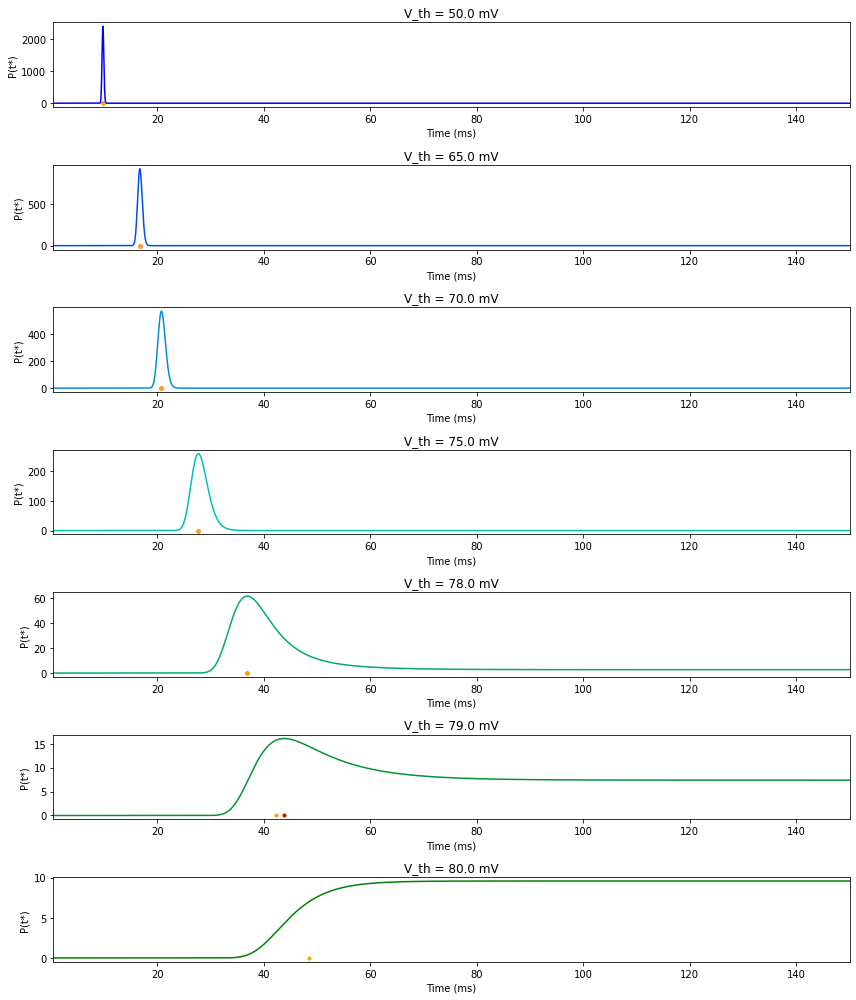

In [389]:
v_ths = [0.05, 0.065, 0.07, 0.075, 0.078, 0.079, 0.08]
n_steps = len(v_ths)
fig, axs = plt.subplots(n_steps, 1, figsize=(12, 2 * n_steps), tight_layout=True)
t = np.linspace(0.0005, 0.15, 100000)
l = 10000

a_prime = 0.8 * a

print('a_prime', a_prime)

colors_1 = [c.hex for c in list(Color('blue').range_to(Color('green'), n_steps))]
colors_2 = [c.hex for c in list(Color('orange').range_to(Color('red'), n_steps))]

for i, v_th in enumerate(v_ths):
    
    k_min = v_th / (a_prime * TAU)
    n_top = poisson_prob_over_k(np.floor(k_min - 1),  l)
    n_bot = poisson_prob_over_k(np.floor(k_min),  l)
    r_N = n_top/n_bot
    
    p = prob_t(v_th, TAU, a_prime, l, t)
    
    p_norm = np.sum(p) * ((t.max() - t.min()) / len(t))
#     print(p_norm)

    axs[i].plot(t*1000, p / p_norm, c=colors_1[i], zorder=1)
    t_delay_s = t_delay(v_th, TAU, a_prime, l)
    t_delay_s_corrected = t_delay(v_th, TAU, a_prime, l * r_N)

    axs[i].scatter(np.array([t_delay_s])*1000, [0], color='red', s=10, zorder=10)
    axs[i].scatter(np.array([t_delay_s_corrected])*1000, [0], color='orange', s=10, zorder=10)
    axs[i].set_xlim(t.min()*1000, t.max()*1000)
    # axs[i].set_ylim(0, 0.04)
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('P(t*)')
    axs[i].set_title(f'V_th = {v_th * 1000} mV')
    
# for i, a_prime in enumerate(np.linspace(0.4 * a, a, n_steps)):
#     p = prob_t(0.054, TAU, a_prime, 10000, t)
#     p_norm = np.sum(p) / len(t) * (t.max() - t.min())
#     print(p_norm)
#     axs[i].plot(t, p, '--', c=colors_1[i], zorder=1)
#     t_delay_s = t_delay(0.054, TAU, a_prime, 10000)
#     # print(t_delay_s)
#     axs[i].scatter([t_delay_s], [0], color='red', s=3, zorder=10)
    

In [320]:
NUM_SAMPLES = 1000

# EPSP size vs E weight
t = np.arange(0, .12, S.DT)

spks_u_base = np.zeros((len(t), MAX_INPUTS), dtype=int)

first_spk_ts = np.zeros((len(v_ths), NUM_SAMPLES))

for i_v, v_th in enumerate(v_ths):
    
    ntwk = LIFNtwkI(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=v_th,
        v_r=0,
        t_r=M.T_R_E,
        w_r=np.zeros([1]*2),
        w_u=0.8 * M.W_E_E_F * np.ones([1, MAX_INPUTS]),
    )
    
    for i_s in range(NUM_SAMPLES):
        
        spks_u = copy(spks_u_base)
        spks_u[:, 0] = np.random.poisson(l * S.DT, (len(t)))
    
        rsp = ntwk.run(
            dt=S.DT,
            clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
            i_ext=np.zeros(len(t)),
            spks_u=spks_u)
        
        first_spk_ts[i_v, i_s] = rsp.spks_t[0]
        
print(first_spk_ts.mean(axis=1))

[0.0098215 0.0164165 0.0202545 0.0251479 0.029601  0.0314481 0.0338614]


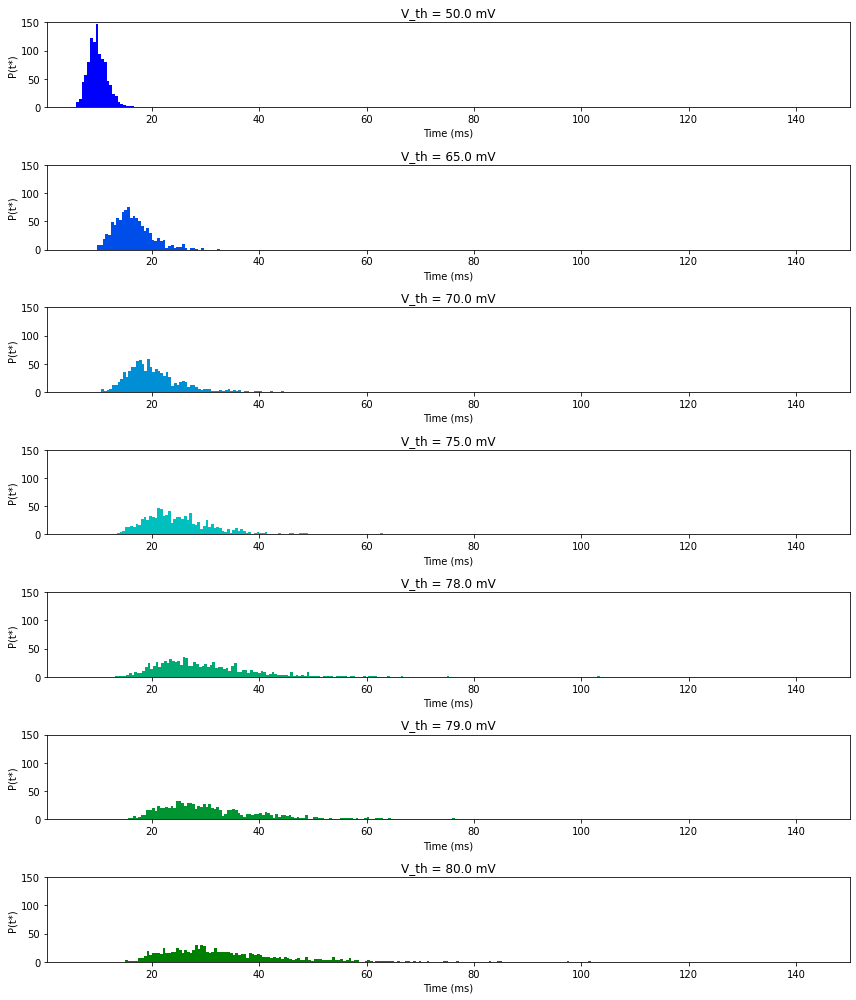

In [393]:
# plot
fig, axs = plt.subplots(len(v_ths), 1, figsize=(12, 2 * len(v_ths)), tight_layout=True)

t_bin_size = 5 * S.DT * 1000
# weights = np.ones(NUM_SAMPLES) / NUM_SAMPLES / t_bin_size
y_scale = 0.3

for i, v_th in enumerate(v_ths):
    spks_ts = first_spk_ts[i, :]
    t_range = (spks_ts.max() - spks_ts.min()) * 1000
    n_bins = int(t_range/t_bin_size)
    axs[i].hist(first_spk_ts[i, :] * 1000, bins=n_bins, color=colors_1[i])
    axs[i].set_xlim(t.min() * 1000, t.max() * 1000)
    axs[i].set_ylim(0, 150)
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('P(t*)')
    axs[i].set_title(f'V_th = {v_th * 1000} mV')

#     t_delay_s = t_delay(v_th, TAU, a_prime, l)
#     axs[i].plot([t_delay_s * 1000] * 1000, np.linspace(0, y_scale, 1000), '--', c='red')
    
#     k_min = v_th / (a_prime * TAU)
#     n_top = poisson_prob_over_k(np.floor(k_min - 1),  l)
#     n_bot = poisson_prob_over_k(np.floor(k_min),  l)
#     r_N = n_top/n_bot
    
#     t_delay_s_corrected = t_delay(v_th, TAU, a_prime, l * r_N)
#     axs[i].plot([t_delay_s_corrected * 1000] * 1000, np.linspace(0, y_scale, 1000), '--', c='orange')